Imported necessary libraries, and the data from "historic_home_data.csv" was manually selected for and cleaned during that process.

In [71]:
import pandas as pd
import os 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pymongo.mongo_client import MongoClient 
from pymongo.server_api import ServerApi


uri = os.getenv("MONGOAUTH_URI")

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

df = pd.read_csv('historic_home_data.csv', parse_dates=['date'])
df.drop('price', axis=1, inplace=True)
print(df)
df['date'] = pd.to_datetime(df['date'])

      id       date  adjusted_price    zip
0      1 2024-09-01          227700  24060
1      1 2024-08-01          229400  24060
2      1 2024-07-01          220600  24060
3      1 2024-06-01          219700  24060
4      1 2024-05-01          218900  24060
...   ..        ...             ...    ...
5965  50 2015-01-01          188500  24060
5966  50 2014-12-01          135800  24060
5967  50 2014-11-01          135300  24060
5968  50 2014-10-01          137300  24060
5969  50 2014-09-01          137400  24060

[5970 rows x 4 columns]


C:\Users\jchen\AppData\Local\Temp\ipykernel_37068\1270063887.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('historic_home_data.csv', parse_dates=['date'])


Data is splitted into multiple individual DataFrames to conduct specific time series analysis to determine a more accurate home price trend. 

In [72]:
df_bb = df[df['zip'] == 24060]
print(df_bb.head())

df_cb = df[df['zip'] == 24073]
print(df_cb.head())

df_rnk_1 = df[df['zip'] == 24012]
print(df_rnk_1.head())

df_rnk_2 = df[df['zip'] == 24014] 
print(df_rnk_2.head())

df_rnk_3 = df[df['zip'] == 24016]
print(df_rnk_3.head())

   id       date  adjusted_price    zip
0   1 2024-09-01          227700  24060
1   1 2024-08-01          229400  24060
2   1 2024-07-01          220600  24060
3   1 2024-06-01          219700  24060
4   1 2024-05-01          218900  24060
      id       date  adjusted_price    zip
1981  18 2024-09-01          293000  24073
1982  18 2024-08-01          302800  24073
1983  18 2024-07-01          319200  24073
1984  18 2024-06-01          334800  24073
1985  18 2024-05-01          355000  24073
      id       date  adjusted_price    zip
4879  42 2024-09-01          231200  24012
4880  42 2024-08-01          232600  24012
4881  42 2024-07-01          239900  24012
4882  42 2024-06-01          245900  24012
4883  42 2024-05-01          246400  24012
      id       date  adjusted_price    zip
5000  43 2024-09-01          499600  24014
5001  43 2024-08-01          495600  24014
5002  43 2024-07-01          492000  24014
5003  43 2024-06-01          497200  24014
5004  43 2024-05-01          

Now, I am going to average the home price data points that have the same dates to make an average home price over time (2014-2024). This is going to be used as the average home price over time to examine trends within a specific zipcode. 

        date  adjusted_price
0 2014-09-01       306045.00
1 2014-10-01       311475.00
2 2014-11-01       308075.00
3 2014-12-01       312624.95
4 2015-01-01       323185.00


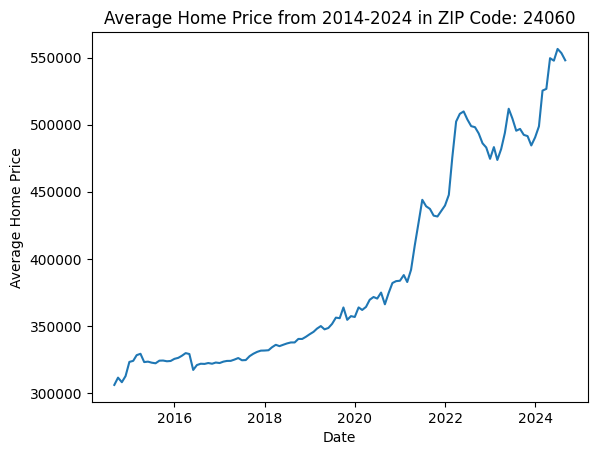

        date  adjusted_price
0 2014-09-01   185225.000000
1 2014-10-01   185312.500000
2 2014-11-01   183129.166667
3 2014-12-01   184070.791667
4 2015-01-01   186629.166667


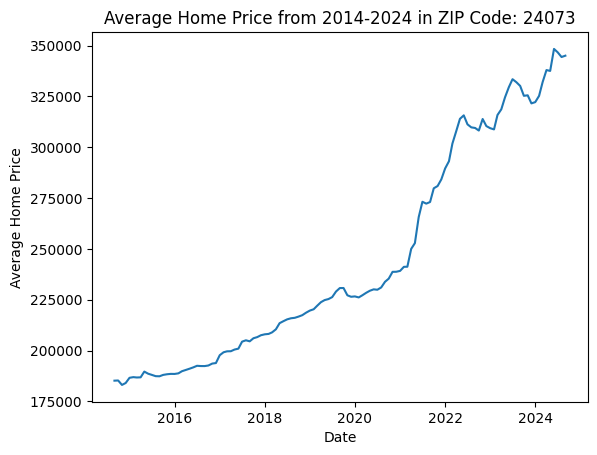

        date  adjusted_price
0 2014-09-01        143700.0
1 2014-10-01        144700.0
2 2014-11-01        146900.0
3 2014-12-01        147100.0
4 2015-01-01        143500.0


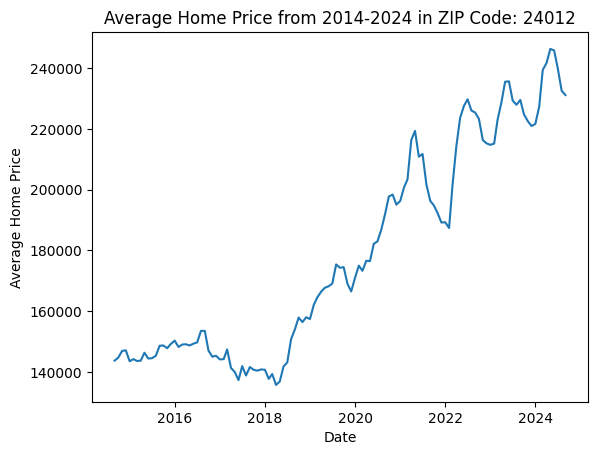

        date  adjusted_price
0 2014-09-01        187650.0
1 2014-10-01        187650.0
2 2014-11-01        189000.0
3 2014-12-01        191100.0
4 2015-01-01        191100.0


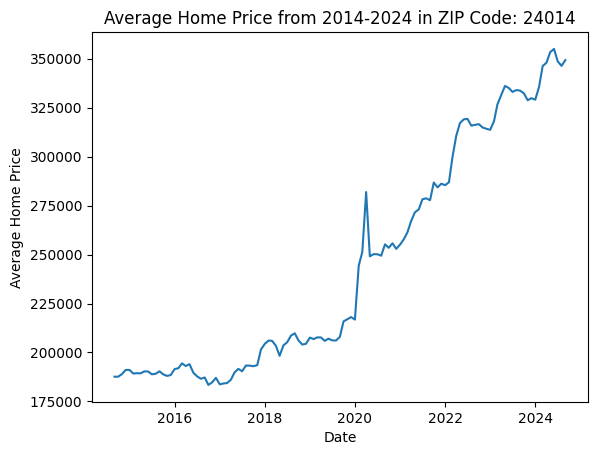

        date  adjusted_price
0 2014-09-01        149100.0
1 2014-10-01        148700.0
2 2014-11-01        147900.0
3 2014-12-01        149400.0
4 2015-01-01        151100.0


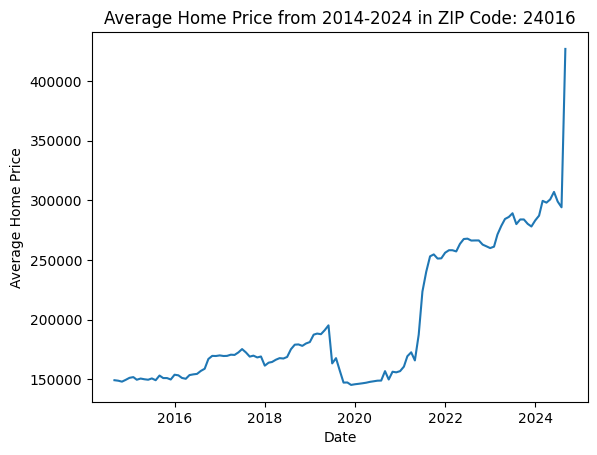

In [73]:
import matplotlib.pyplot as plt

def avg_price_and_plot(db: pd.DataFrame, zipcode: int):
    avg = db.groupby('date')['adjusted_price'].mean()
    avg_df = avg.reset_index()
    print(avg_df.head())
    plt.plot(avg_df['date'], avg_df['adjusted_price'])
    plt.title(f'Average Home Price from 2014-2024 in ZIP Code: {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Average Home Price')
    
    plt.show()
    return avg_df

bb_avg_df = avg_price_and_plot(df_bb, 24060)

cb_avg_df = avg_price_and_plot(df_cb, 24073)

rnk_1_avg_df = avg_price_and_plot(df_rnk_1, 24012)

rnk_2_avg_df = avg_price_and_plot(df_rnk_2, 24014)

rnk_3_avg_df = avg_price_and_plot(df_rnk_3, 24016)

getting train and test sets

In [ ]:
from sklearn.model_selection import train_test_split



Using ADF test to check for p-value that is greater than 0.05

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)

In [76]:
# BELOW IS WRITTEN BY MIG 
train_size = int(120 * 0.8) # out of the 10 years of data, train with first 8, test with later 2



bb_train, bb_test = bb_avg_df.iloc[:train_size], bb_avg_df.iloc[train_size:]


def find_d(series, max_d=2):
    def check_stationarity(series):
        result = adfuller(series)
        return result[1] < 0.05
    
    if check_stationarity(series):
        return 0
    
    for d in range(1, max_d+1):
        series = series.diff().dropna()
        if check_stationarity(series):
            return d
        
    return max_d

def plot_acf_pacf(series):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    plot_acf(series.dropna(), ax=ax[0], lags=40)
    ax[0].set_title('ACF Plot')

    plot_pacf(series.dropna(), ax=ax[1], lags=40)
    ax[1].set_title('PACF Plot')

    plt.show()


print(f'd parameter for ZIP Code 24060: '{find_d(bb_avg_df)})




# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# plot_acf(bb_train_diff, lags=20, ax=plt.gca())
# plt.title('ACF Plot')
# plt.subplot(122)
# plot_pacf(bb_train_diff, lags=20, ax=plt.gca())
# plt.title('PACF Plot')
# plt.show()

# bb_model = ARIMA(bb_train['adjusted_price'], order=bb_auto_model.order)
# bb_model_fit = bb_model.fit()